# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue deposition]

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [243]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [261]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year=="2011"').reset_index().iloc[:,1:]
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       712 non-null    object 
 1   Latitude   712 non-null    float64
 2   Longitude  712 non-null    float64
 3   Magnitude  712 non-null    float64
 4   Year       712 non-null    object 
dtypes: float64(3), object(2)
memory usage: 27.9+ KB


<AxesSubplot:>

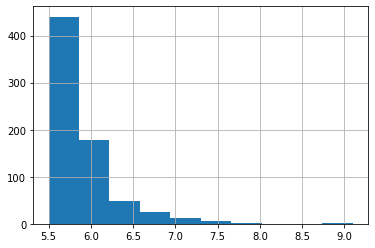

In [262]:
_df.Magnitude.hist()

##### 2. $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [263]:
f = _df.loc[:,"Magnitude"]

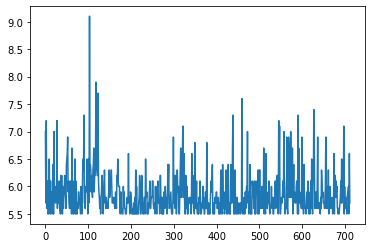

In [264]:
#collapse
plt.plot(f,'-')

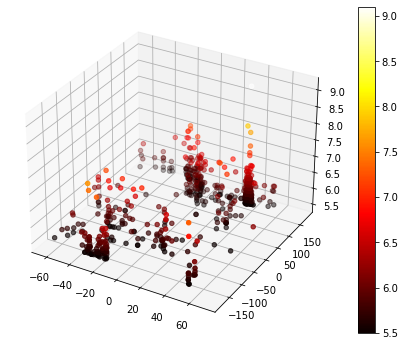

In [265]:
#collapse
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [269]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2011-2010)]

In [270]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [271]:
#collapse
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2010,2011))).add_to(m)
m

##### 3. 비유클리드 공간에서의 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$$

In [518]:
def dist(i,j):
    a1=abs(_df.Latitude[j] - _df.Latitude[i])
    a2=abs(_df.Latitude[j] + _df.Latitude[i])
    b1=abs(_df.Longitude[j] - _df.Longitude[i])
    b2=abs(_df.Longitude[j] + _df.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

---

In [460]:
from haversine import haversine

In [461]:
def dist(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

In [516]:
def weight(i,j,theta=50000,kappa=100000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

---

##### 4. 거리를 이용한 a weighted adjacency matrix $W_{i,j}$ 정의

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [519]:
def weight(i,j,theta=80,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [520]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

(array([  5380.,   9416.,  14282.,  18892.,  18254.,  23150.,  42292.,
         42614., 111648., 221016.]),
 array([0.07657981, 0.16892183, 0.26126385, 0.35360587, 0.44594789,
        0.5382899 , 0.63063192, 0.72297394, 0.81531596, 0.90765798,
        1.        ]),
 <BarContainer object of 10 artists>)

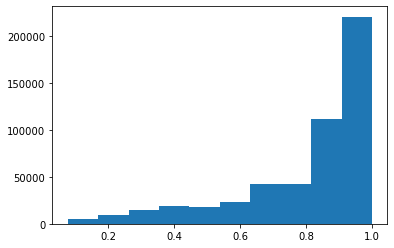

In [521]:
#collapse
plt.hist(W.reshape(-1))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [522]:
D = np.diag(W.sum(axis=1))

In [523]:
D

array([[449.5150995 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 560.11961133,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 486.93045762, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 590.50933104,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        546.71154293,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 597.37143809]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [524]:
L = D - W

In [525]:
L

array([[ 4.48515100e+02, -8.57648748e-01, -9.81632894e-01, ...,
        -4.16767720e-01, -8.75550444e-01, -5.69731855e-01],
       [-8.57648748e-01,  5.59119611e+02, -8.59449506e-01, ...,
        -6.90386662e-01, -8.37120244e-01, -7.06914182e-01],
       [-9.81632894e-01, -8.59449506e-01,  4.85930458e+02, ...,
        -4.77371035e-01, -9.47374271e-01, -6.70049523e-01],
       ...,
       [-4.16767720e-01, -6.90386662e-01, -4.77371035e-01, ...,
         5.89509331e+02, -6.08124366e-01, -8.47563281e-01],
       [-8.75550444e-01, -8.37120244e-01, -9.47374271e-01, ...,
        -6.08124366e-01,  5.45711543e+02, -8.42564580e-01],
       [-5.69731855e-01, -7.06914182e-01, -6.70049523e-01, ...,
        -8.47563281e-01, -8.42564580e-01,  5.96371438e+02]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [526]:
λ, Ψ = np.linalg.eig(L)

In [527]:
Λ = np.diag(λ)

##### 8. 주성분 분석
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = \sum_{1}^{n} comp1^2,\sum_{1}^{n} comp2^2,…,\sum_{1}^{n} compn^2$
- $p = \frac{p}{\sum(p)}$

In [528]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [529]:
def p(i):
    return sum(comp(i)**2)

In [530]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [531]:
varprop = array_1/array_1.sum()

In [532]:
#collapse
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [533]:
#collapse_output
_indexlst

[698,
 491,
 440,
 694,
 587,
 44,
 420,
 399,
 152,
 389,
 424,
 408,
 493,
 625,
 642,
 49,
 93,
 94,
 230,
 585,
 37,
 494,
 118,
 67,
 647]

(0.0, 40.0)

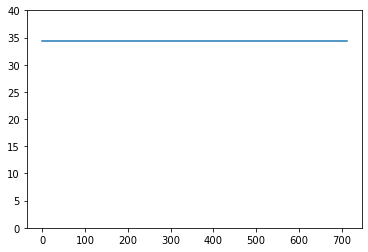

In [534]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

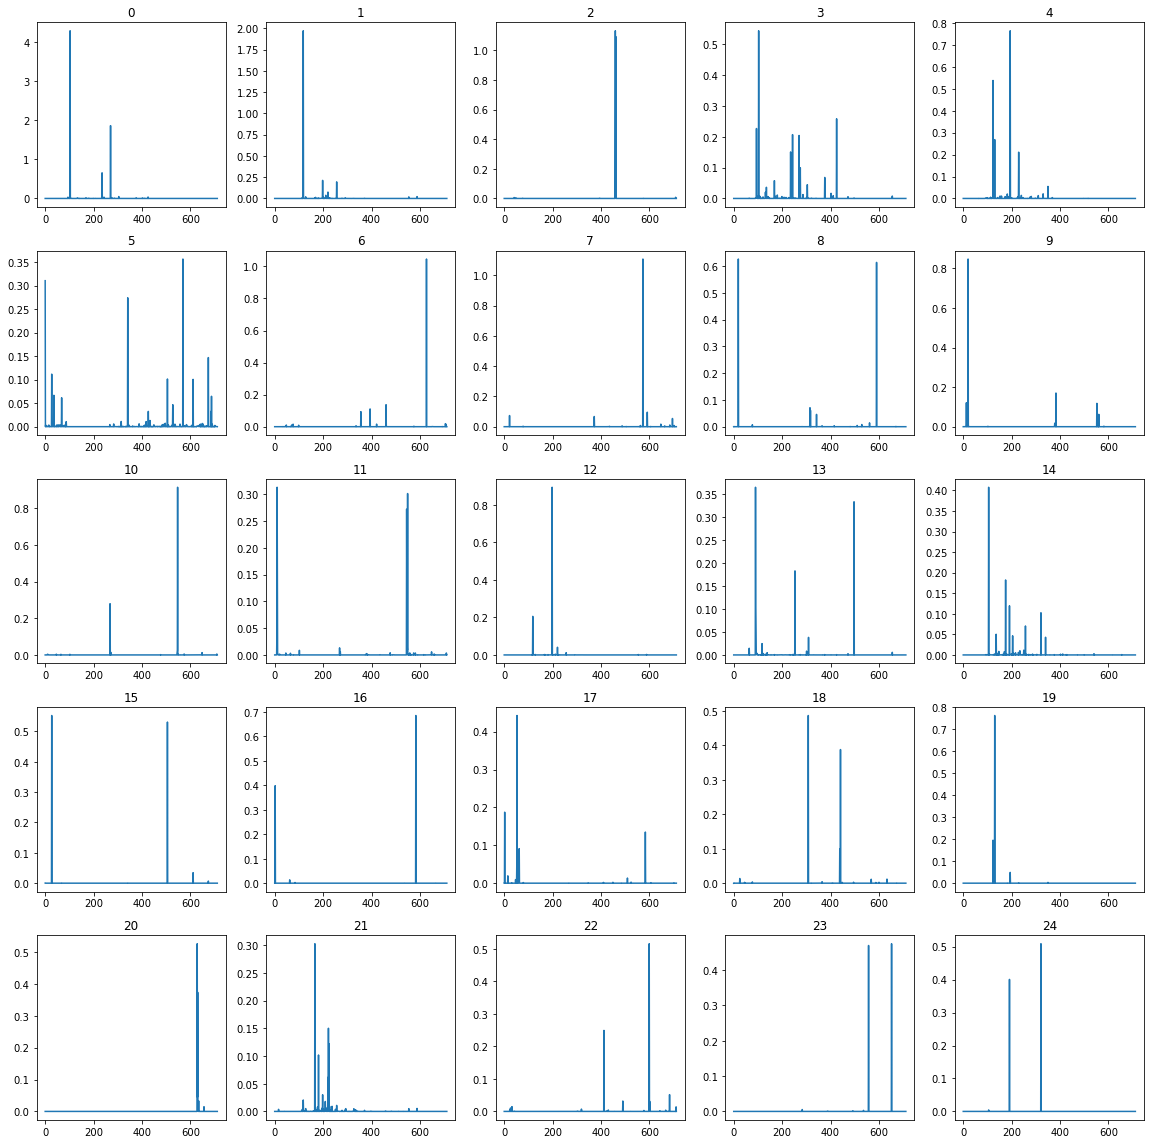

In [535]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

In [536]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [537]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [538]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [539]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [540]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [541]:
_df["comp1"] = comp1

In [542]:
_df["comp2"] = comp2

In [543]:
_df["comp3"] = comp3

In [544]:
_df["comp4"] = comp4

In [545]:
_df["comp5"] = comp5

#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
__lst1=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
__lst2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
__lst3=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
__lst4=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
__lst5=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,9]].\
to_numpy().tolist() for i in range(2011-2010)]

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2010,2011))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2010,2011))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2010,2011))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2010,2011))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2010,2011))).add_to(_m)
_m

#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst6,radius=5,index=list(range(2010,2011))).add_to(_m)
_m

---

##### **Survey_Graph Signal Processing(fig3)**

In [546]:
_G = nx.Graph(W-np.identity(len(f)))

In [547]:
_pos = nx.spring_layout(_G,iterations=20)

In [548]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

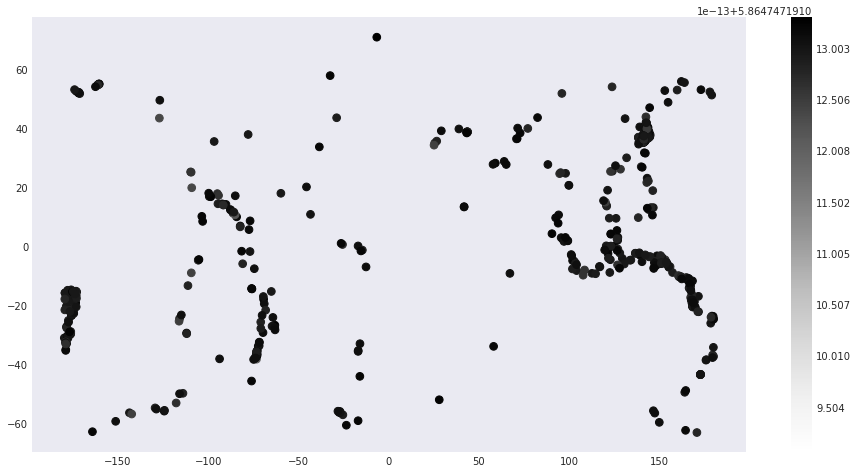

In [549]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

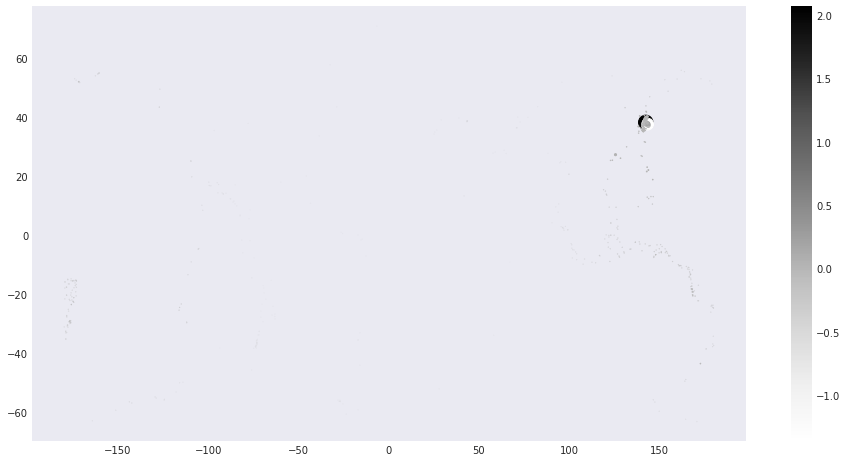

In [550]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

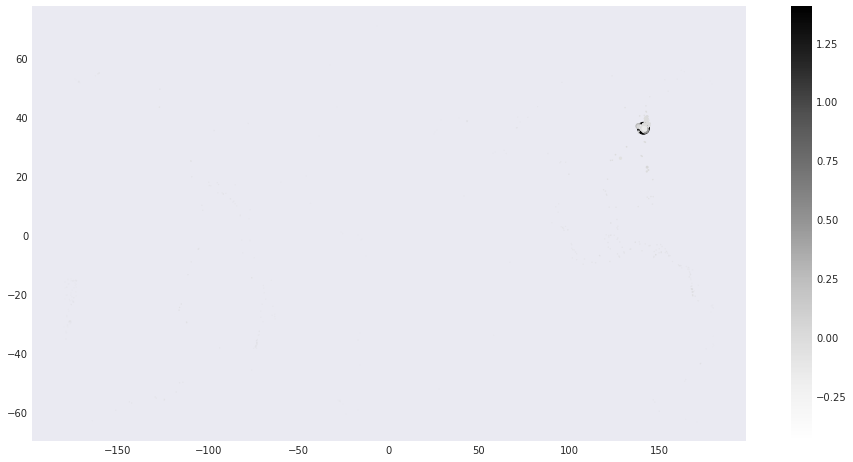

In [551]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

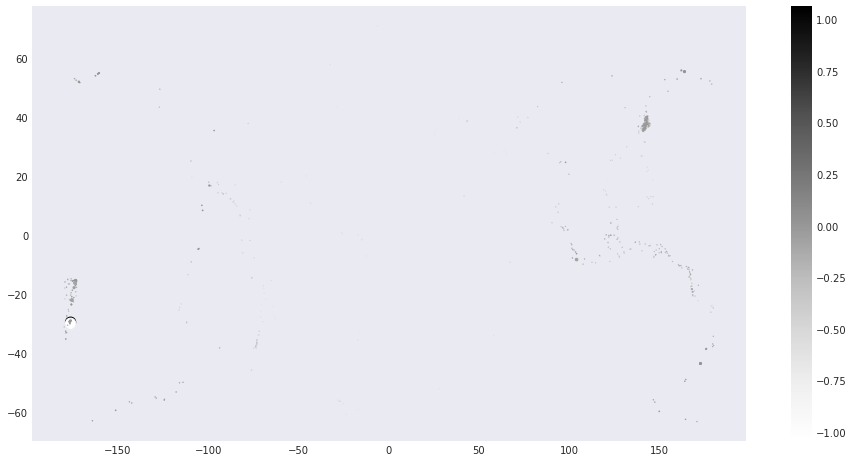

In [552]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

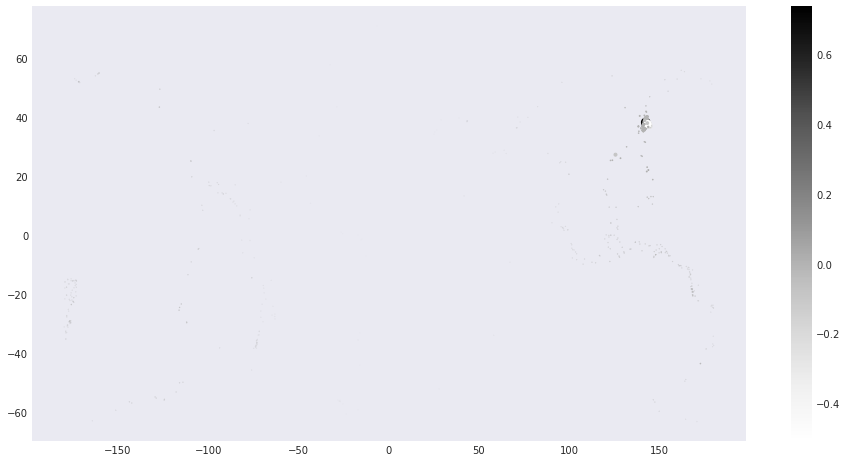

In [553]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

---